In [1]:
# ------------------ Imports ------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb

In [2]:
# ------------------ 1. Load Dataset ------------------
df = pd.read_csv(r"C:\Users\maher\Desktop\covertype.csv")


In [3]:
# ------------------ 2. Data Cleaning ------------------
# Check for missing values
if df.isnull().sum().any():
    print("Missing values found! Filling with 0.")
    df.fillna(0, inplace=True)

In [4]:
# ------------------ 3. Separate Features & Target ------------------
X = df.drop(columns=["Cover_Type"])
y = df["Cover_Type"]

# Convert labels from 1–7 → 0–6 for XGBoost
y = y - 1

In [5]:
# ------------------ 4. Identify Numeric & Categorical Features ------------------
numeric_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways", "Hillshade_9am", "Hillshade_Noon",
    "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"
]

categorical_features = [col for col in X.columns if col not in numeric_features]


In [6]:
# ------------------ 5. Scale Only Numeric Features ------------------
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_features])

# Keep categorical as-is (already 0/1)
X_categorical = X[categorical_features].values

# Combine scaled numeric + categorical
X_processed = np.hstack((X_numeric_scaled, X_categorical))


In [7]:

# ------------------ 6. Train/Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

In [8]:
# ------------------ 7. Train XGBoost ------------------
model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=7,
    eval_metric="mlogloss",
    random_state=42
)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=7, ...)

In [9]:
# ------------------ 8. Predictions & Evaluation ------------------
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     42368
           1       0.87      0.90      0.88     56661
           2       0.89      0.91      0.90      7151
           3       0.88      0.85      0.87       549
           4       0.89      0.58      0.71      1899
           5       0.85      0.80      0.82      3473
           6       0.95      0.91      0.93      4102

    accuracy                           0.87    116203
   macro avg       0.88      0.83      0.85    116203
weighted avg       0.87      0.87      0.87    116203



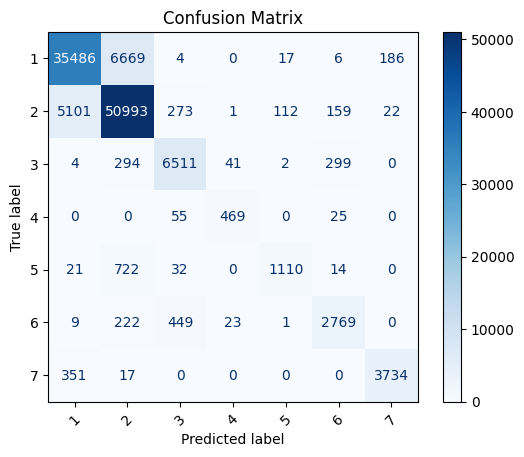

In [10]:
# ------------------ 9. Confusion Matrix ------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(1, 8))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


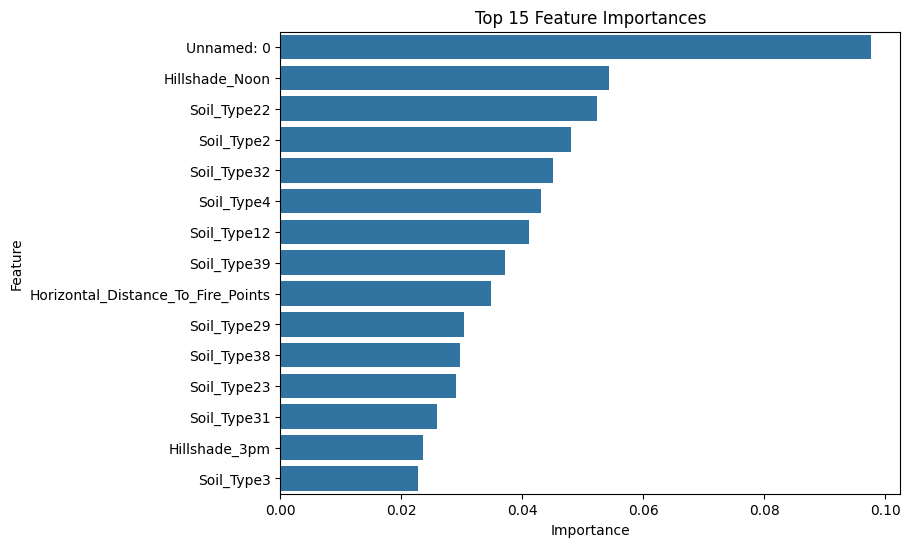

In [12]:
# ------------------ 10. Feature Importance ------------------
importance = model.feature_importances_
feat_names = numeric_features + categorical_features

importance_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

# Plot top 15 features
plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(15),)
plt.title("Top 15 Feature Importances")
plt.show()
